In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

c:\users\azerate\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [11]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

    
print('Done!')

np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('Y_train.npy',Y_train)
import pickle
with open('sizes_test.pkl', 'wb') as f:
    pickle.dump(sizes_test, f)
#X_train= np.swapaxes(X_train,1,2)
#X_train =np.swapaxes(X_train,1,3)

#X_test= np.swapaxes(X_test,1,2)
#X_test =np.swapaxes(X_test,1,3)

#Y_train= np.swapaxes(Y_train,1,2)
#Y_train =np.swapaxes(Y_train,1,3)

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████| 670/670 [03:34<00:00,  3.13it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████| 65/65 [00:01<00:00, 43.45it/s]


Done!


c:\users\azerate\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


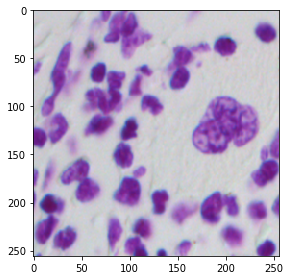

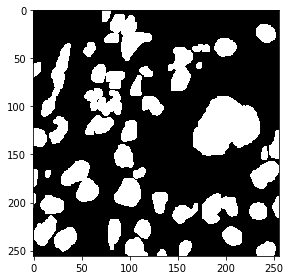

In [12]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
#K.image_data_format()

'channels_last'

In [9]:
import pickle
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
Y_train = np.load('Y_train.npy')
with open('sizes_test.pkl', 'rb') as f:
    sizes_test = pickle.load(f)

In [13]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [14]:
from keras.engine.topology import Layer
from keras.layers import Cropping2D
def cropping( o1 , o2 , i  ):
    o_shape2 = Model( i  , o2 ).output_shape
    outputHeight2 = o_shape2[2]
    outputWidth2 = o_shape2[3]

    o_shape1 = Model( i  , o1 ).output_shape
    outputHeight1 = o_shape1[2]
    outputWidth1 = o_shape1[3]

    cx = abs( outputWidth1 - outputWidth2 )
    cy = abs( outputHeight2 - outputHeight1 )

    if outputWidth1 > outputWidth2:
        o1 = Cropping2D( cropping=((0,0) ,  (  0 , cx )) )(o1) #, data_format=ch 
    else:
        o2 = Cropping2D( cropping=((0,0) ,  (  0 , cx ))  )(o2) #, data_format=ch
    
    if outputHeight1 > outputHeight2 :
        o1 = Cropping2D( cropping=((0,cy) ,  (  0 , 0 ))  )(o1) #, data_format=ch
    else:
        o2 = Cropping2D( cropping=((0, cy ) ,  (  0 , 0 )) )(o2) #, data_format=ch 

    return o1 , o2 

In [15]:
from keras.layers import BatchNormalization, Add, Reshape, Permute, Activation
from keras.regularizers import l2
import h5py
from keras.optimizers import Adam
#weight_decay=0.005


#ch = 'channels_first' 

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 896         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 32) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 256, 256, 32) 13856       concatenate_8[0][0]              
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 32) 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 32) 9248        dropout_18[0][0]                 
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 1)  33          conv2d_37[0][0]                  
Total params: 4,529,137
Trainable params: 4,529,137
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('unet-newmodel-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
592/603 [============================>.] - ETA: 3:49 - loss: 0.7315 - mean_iou: 0.0000e+ - ETA: 2:04 - loss: 0.6718 - mean_iou: 0.2041   - ETA: 1:29 - loss: 0.6484 - mean_iou: 0.27 - ETA: 1:11 - loss: 0.6195 - mean_iou: 0.31 - ETA: 1:00 - loss: 0.5921 - mean_iou: 0.33 - ETA: 53s - loss: 0.6848 - mean_iou: 0.3460 - ETA: 47s - loss: 0.6518 - mean_iou: 0.353 - ETA: 42s - loss: 0.6280 - mean_iou: 0.359 - ETA: 39s - loss: 0.6047 - mean_iou: 0.364 - ETA: 36s - loss: 0.5820 - mean_iou: 0.368 - ETA: 33s - loss: 0.5699 - mean_iou: 0.372 - ETA: 31s - loss: 0.5500 - mean_iou: 0.376 - ETA: 28s - loss: 0.5454 - mean_iou: 0.379 - ETA: 27s - loss: 0.5341 - mean_iou: 0.382 - ETA: 25s - loss: 0.5248 - mean_iou: 0.384 - ETA: 23s - loss: 0.5123 - mean_iou: 0.386 - ETA: 22s - loss: 0.5219 - mean_iou: 0.388 - ETA: 20s - loss: 0.5139 - mean_iou: 0.390 - ETA: 19s - loss: 0.5063 - mean_iou: 0.392 - ETA: 18s - loss: 0.4999 - mean_iou: 0.393 - ETA: 16s - l

592/603 [============================>.] - ETA: 28s - loss: 0.0976 - mean_iou: 0.638 - ETA: 27s - loss: 0.1163 - mean_iou: 0.639 - ETA: 26s - loss: 0.1163 - mean_iou: 0.639 - ETA: 25s - loss: 0.1070 - mean_iou: 0.640 - ETA: 24s - loss: 0.1054 - mean_iou: 0.640 - ETA: 23s - loss: 0.1071 - mean_iou: 0.641 - ETA: 23s - loss: 0.1103 - mean_iou: 0.641 - ETA: 22s - loss: 0.1073 - mean_iou: 0.642 - ETA: 21s - loss: 0.1089 - mean_iou: 0.642 - ETA: 20s - loss: 0.1076 - mean_iou: 0.643 - ETA: 19s - loss: 0.1098 - mean_iou: 0.643 - ETA: 19s - loss: 0.1096 - mean_iou: 0.644 - ETA: 18s - loss: 0.1069 - mean_iou: 0.644 - ETA: 17s - loss: 0.1077 - mean_iou: 0.645 - ETA: 16s - loss: 0.1070 - mean_iou: 0.645 - ETA: 16s - loss: 0.1067 - mean_iou: 0.646 - ETA: 15s - loss: 0.1061 - mean_iou: 0.646 - ETA: 14s - loss: 0.1079 - mean_iou: 0.647 - ETA: 13s - loss: 0.1062 - mean_iou: 0.647 - ETA: 13s - loss: 0.1039 - mean_iou: 0.648 - ETA: 12s - loss: 0.1047 - mean_iou: 0.648 - ETA: 11s - loss: 0.1048 - mean_io

512/603 [========================>.....] - ETA: 27s - loss: 0.1042 - mean_iou: 0.717 - ETA: 27s - loss: 0.1145 - mean_iou: 0.718 - ETA: 26s - loss: 0.1054 - mean_iou: 0.718 - ETA: 25s - loss: 0.1082 - mean_iou: 0.718 - ETA: 24s - loss: 0.1074 - mean_iou: 0.718 - ETA: 23s - loss: 0.1041 - mean_iou: 0.718 - ETA: 22s - loss: 0.0967 - mean_iou: 0.718 - ETA: 22s - loss: 0.0923 - mean_iou: 0.719 - ETA: 21s - loss: 0.0977 - mean_iou: 0.719 - ETA: 20s - loss: 0.0957 - mean_iou: 0.719 - ETA: 20s - loss: 0.0961 - mean_iou: 0.719 - ETA: 19s - loss: 0.0965 - mean_iou: 0.719 - ETA: 18s - loss: 0.0956 - mean_iou: 0.719 - ETA: 17s - loss: 0.0946 - mean_iou: 0.720 - ETA: 17s - loss: 0.0974 - mean_iou: 0.720 - ETA: 16s - loss: 0.0961 - mean_iou: 0.720 - ETA: 15s - loss: 0.0970 - mean_iou: 0.720 - ETA: 14s - loss: 0.0969 - mean_iou: 0.720 - ETA: 14s - loss: 0.0961 - mean_iou: 0.720 - ETA: 13s - loss: 0.0983 - mean_iou: 0.720 - ETA: 12s - loss: 0.0980 - mean_iou: 0.721 - ETA: 11s - loss: 0.0964 - mean_io

In [72]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [73]:
from keras.optimizers import Adam

model = load_model('unet-newmodel-dsbowl2018-1.h5')
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999,epsilon=None, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[mean_iou])
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('unet-newmodel-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

ValueError: Unknown metric function:mean_iou

In [54]:
# Predict on train, val and test
model = load_model('unet-newmodel-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 1s 18ms/step


c:\users\azerate\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


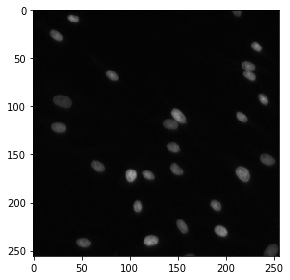

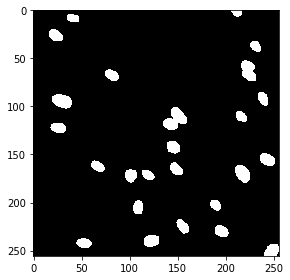

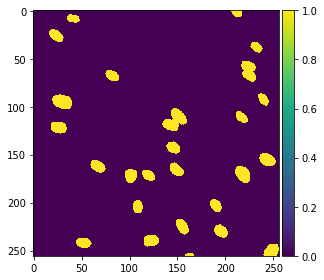

In [55]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

c:\users\azerate\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


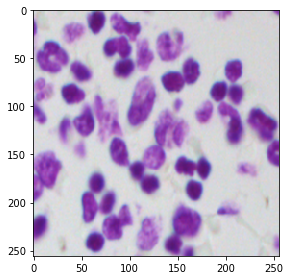

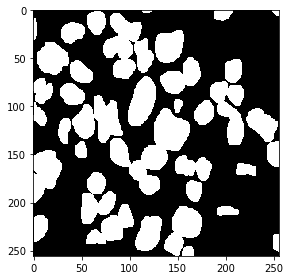

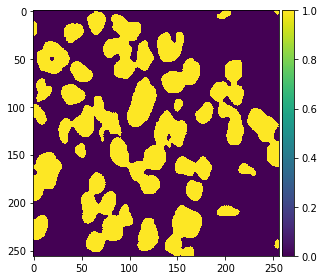

In [56]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [57]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [58]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))


In [59]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-unetmodified-dsbowl2018-3.csv', index=False)
